# **User Identification From Walking Activity**

**Abstract**<br><br>
The dataset collects data from an Android smartphone positioned in the chest pocket. Accelerometer Data are collected from 22 participants walking in the wild over a predefined path. The dataset is intended for Activity Recognition research purposes. It provides challenges for identification and authentication of people using motion patterns.

**Relevant Information**
   - The dataset collects data from an Android smartphone accelerometer positioned in the chest pocket
   - Sampling frequency of the accelerometer: DELAY_FASTEST with network connections disabled
   - Number of Participants: 22
   - Data Format: CSV

**Dataset Information**
   - Data are separated by participant
   - Each file contains the following information
   - time-step, x acceleration, y acceleration, z acceleration

## Feature selection
Since the dataset is labeled by participant's ID number, the natural technique to employ for solving this problem is "clustering". The dataset for each participant is time series of 3 quantities; acceleration in x, y, and z direction (hereafter denoted as ax, ay, and az) measured by accerometer in an Android cellphone carried in the chest pocket. See the example data for participant 2, 6, and 8 below.

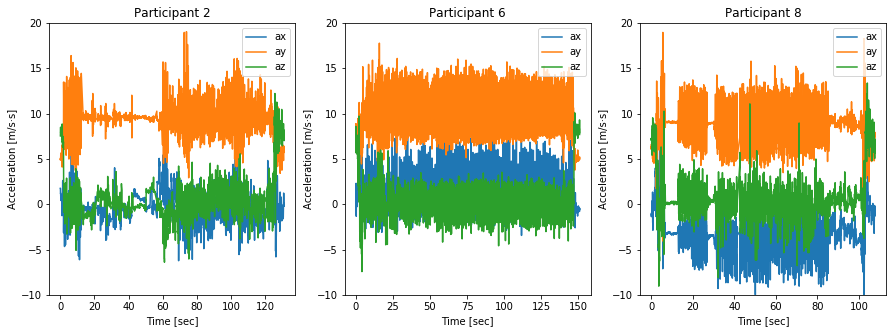

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read-in entire dataset
data = []
for i in range( 1, 23 ):
    data.append( pd.read_csv( 'data/%02d.csv'%i, names = ['t', 'ax', 'ay', 'az']) )

# Plot example data
def plot_data( ID, f, title ):
    f.plot( data[ID-1]['t'], data[ID-1]['ax'], label="ax") # -1 for 0 index
    f.plot( data[ID-1]['t'], data[ID-1]['ay'], label="ay")
    f.plot( data[ID-1]['t'], data[ID-1]['az'], label="az")
    f.set_ylim(-10,20)
    f.set_title( title )
    f.set_xlabel( 'Time [sec]' )
    f.set_ylabel( r'Acceleration [m/s·s]' )
    f.legend( loc='upper right' )
    
fig = plt.figure(figsize=(15,5))
f2 = fig.add_subplot(131)
plot_data( 2, f2, 'Participant 2' )
f6 = fig.add_subplot(132)
plot_data( 6, f6, 'Participant 6' )
f8 = fig.add_subplot(133)
plot_data( 8, f8, 'Participant 8' )

The time stamp is 0.03 seconds on average (but non-uniformly sampled), and therefore the example participants 2, 6, and 8 above have ~3900, ~4900, and ~3500 data points for each variable, respectively. Each data point, however, does not have much information and cannot be used as a training data point. Time series data have meaning only when they are analyzed as series. The strategy we should take is, then, dividing each series into smaller segments and use each segment as one data point to extract the features.

The simplest features are an average value and standard deviation of each variable for a given time segment. Figure below shows a series of average value with standard deviation indicated by the error bars, for the above 3 participants with a segmentation size $\Delta T=10$ (sec).